## 02. Базовые идеи модели `word2vec`

## 02.1 Формирование обучающей выборки

Задачу предсказания следующего слова по предыдущим можно представить как задачу *многоклассовой классификации*, где $y=1$, если данное слово следует за предыдущим, и $y=0$ в противном случае. Обучающую выборку в данном легко получить с помощью
*скользящего окна*.

Рассмотрим строку *«Success is the ability to go from failure to failure without losing your
enthusiasm»* и пройдем по ней окном размера $3$. Таким образом наберется обучающая
выборка, где первые два слова являются **признаками**, а последний столбец – **целевой**
переменной.

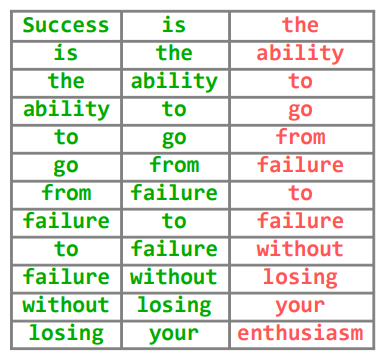

Мы можем представить модель в виде чёрного ящика:

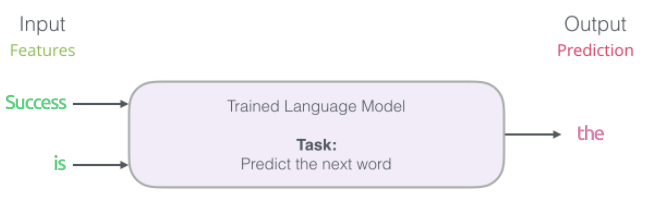

Но на практике модель выдаёт не одно слово. Она выводит оценку вероятности фактически для всех известных слов («словарь» модели варьируется от нескольких тысяч до более миллиона слов). Затем приложение клавиатуры находит слова с самыми высокими баллами и показывает их пользователю.

## 02.2 One-Hot-Encoding

Представить слова обучающей выборки в виде вектора можно с помощью простого пути `One-Hot-Encoding`. Для этого необходимо знать размер словаря (**dictionary size**). 

В данном примере число уникальных слов в представленной строке равно $12$. Тогда:

- $\text{success is} \mapsto X_{1} = \{1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\}$
- $\text{the} \mapsto y_1 = \{0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0\}$

Таким образом проводится оценка вероятностей каждого возможного варианта.

Недостатками данного представления слов являются следующие факторы:

1. Вектора не содержат в себе никакой информации - по сути вектора являются лишь представлением слова в компьютере.

2. Невозможно сравнивать слова

## 02.3 CBOW

Очевидно, что информационная ценность есть у слов и до, и после пробела. Оказывается, учёт в обе стороны (слева и справа) позволяет рассчитать более качественные вектора вложений слова.

Кроме двух слов перед целевым, можно учитывать ещё два слова после него. Пусть в рассмотренном ранее примере
пропущено слово `the`, тогда при ширине окна, равной $5$, признаками будут выступать слова `Success`, `is`, `ability`, `to`.

Данная архитектура называется **Continuous Bag of Words**

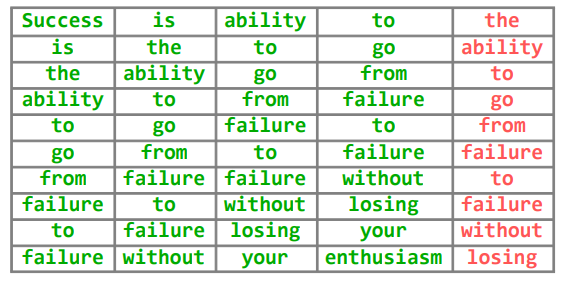

## 02.4 Skip-gram

Архитектура **Skip-gram** устроена несколько иначе. Если *CBoW* предсказывает слово по его окружению, то в архитектуре *Skip-gram*, наоборот, по текущему слову необходимо предсказать его окружение. Тогда обучающая выборка будет представляться в следующем виде:

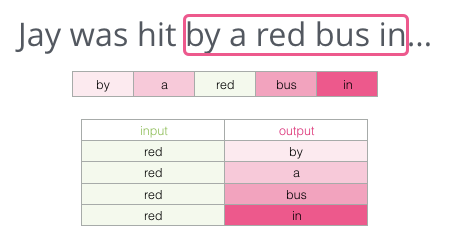

Важно отметить, что обучение на всем имеющемся словаре приводит к необходимости вычислять вероятности для каждого слова (функция softmax). Чтобы этого избежать от задачи многоклассовой классификации переходят к задаче бинарной классификации, где на вход подаются два слово, а выход – метка, являются ли данные слова соседями.

Чтобы обучить модель классификации необходимо добавить отрицательные примеры, то
есть те слова, которые не являются соседними.Но что ввести в качестве выходных слов? Выберем слова произвольно из **словаря** (`random sampling from vocabulary`).

Эта идея родилась под влиянием метода шумосопоставительного оценивания [pdf](http://proceedings.mlr.press/v9/gutmann10a/gutmann10a.pdf). Мы сопоставляем фактический сигнал (положительные примеры соседних слов) с шумом (случайно выбранные слова, которые не являются соседями). Это обеспечивает отличный компромисс между производительностью и статистической эффективностью.

Мы рассмотрели две центральные концепции модели **word2vec** - *Skip gram with Negative Sampling*:

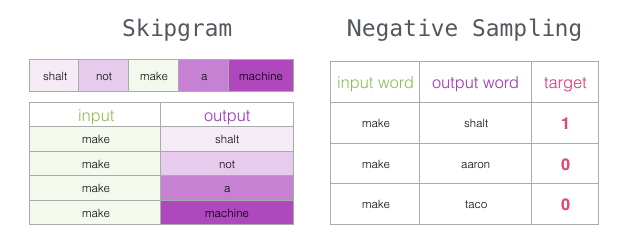

## 02.5 Word2Vec

### 02.5.1 Базовое понимание

Разобрав основные идеи модели *Skip-Gram* и отрицательной выборки, можем перейти к более пристальному рассмотрению процесс обучения *word2vec*.

Сначала предварительно обработаем текст, на котором будем обучаться модель. Определим размер словаря (обозначение - $V$).

Архитектура модели *word2vec* состоит из двух матриц:

- **Embedding** - матрица векторных представлений слов размера $\text{embedding_size} \times V$

- **Context** - матрица контекста.

Сначала инициализируем эти матрицы случайными значениями. Затем начинаем процесс обучения. На каждом этапе берём один положительный пример и связанные с ним отрицательные. Вот наша первая группа:

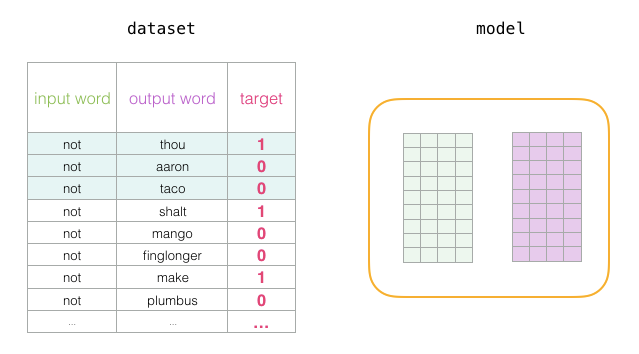

Теперь у нас четыре слова: входное слово not и выходные/контекстные слова thou (фактический сосед), aaron и taco (отрицательные примеры). Начинаем поиск их вложений в матрицах Embedding (для входного слова) и Context(для контекстных слов), хотя в обеих матрицах есть вложения для всех слов из нашего словаря.

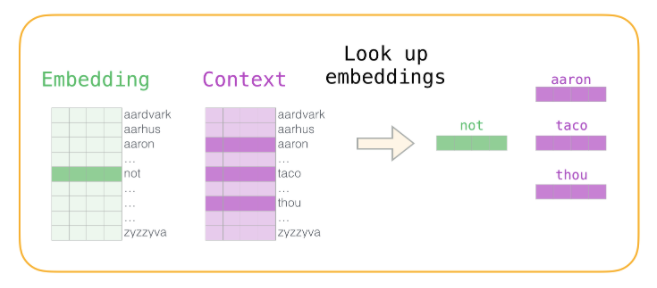

Затем вычисляем скалярное произведение входного вложения с каждым из контекстных вложений. В каждом случае получается число, которое указывает на сходство входных данных и контекстных вложений. Чем меньше скалярное произведение, тем меньше косинусное расстояние между векторами, тем ближе по смыслу данные слова - главная идея **word2vec**

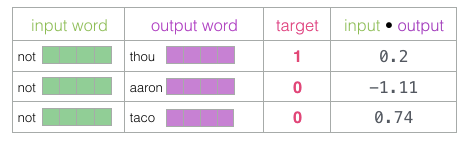

Теперь нужен способ превратить эти оценки в некое подобие вероятностей: все они должны быть положительными числами между 0 и 1. Это отличная задача для логистических уравнений `sigmoid`.

Когда необученная модель сделала прогноз и имея реальную целевую метку для сравнения, давайте посчитаем, сколько ошибок в прогнозе модели. Для этого просто вычитаем оценку sigmoid из целевых меток.

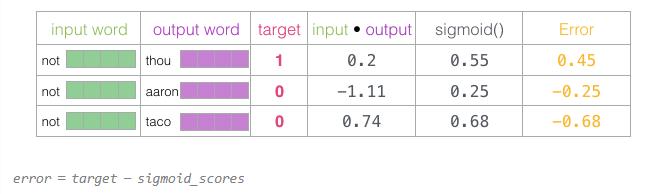

Вот здесь наступает фаза «обучение» из термина «машинное обучение». Теперь мы можем использовать эту оценку ошибок для корректировки вложений not, thou, aaron и taco, чтобы при следующем расчёте результат был бы ближе к целевым оценкам.

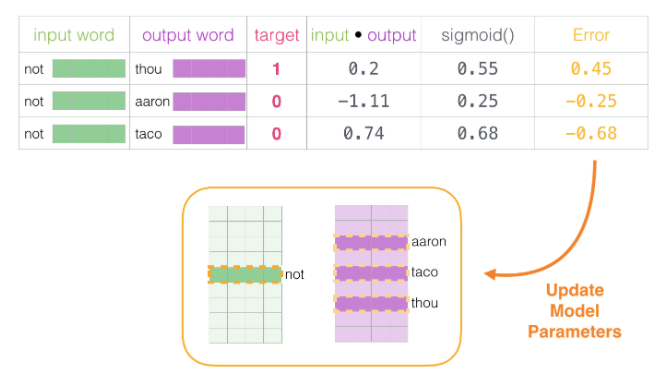

На этом завершается один этап обучения. Мы немного улучшили вложения нескольких слов (not, thou, aaron и taco). Теперь переходим к следующему этапу (следующий положительный образец и связанные с ним отрицательные) и повторяем процесс.

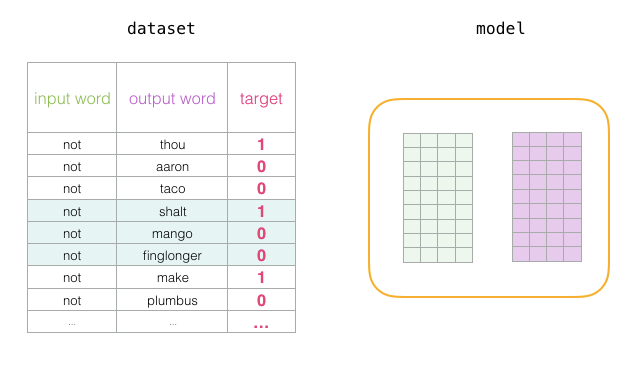

Вложения продолжают улучшаться, пока мы несколько раз циклически прогоняем весь набор данных. Затем можно остановить процесс, отложить матрицу Context и использовать обученную матрицу Embeddings для следующей задачи - матрица представляет собой веса линейной предсказательной модели и после обучения может использоваться для векторного описания слов.

### 02.5.3. Размер окна и количество отрицательных образцов

В процессе обучения `word2vec` два ключевых гиперпараметра — это **размер окна** и **количество отрицательных образцов**.

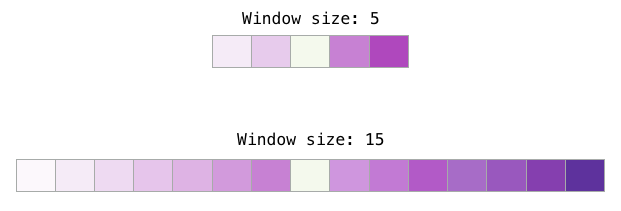

Различные размеры окна подходят для разных задач. Замечено, что меньшие размеры окон (2−15) порождают взаимозаменяемые вложения с похожими индексами (обратите внимание, что антонимы часто взаимозаменяемы, если смотреть на окружающие слова: например, слова «хорошо» и «плохо» часто упоминаются в схожих контекстах). Большие размеры окон (15−50 или даже больше) порождают родственные вложения со схожими индексами. На практике вам часто придётся предоставлять аннотации ради полезного смыслового сходства в вашей задаче. В Gensim размер окна по умолчанию равен 5 (по два слова слева и справа, в дополнение к самому входному слову).

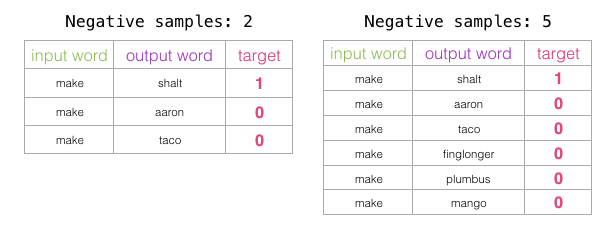

Количество отрицательных образцов — ещё один фактор процесса обучения. Оригинальный документ рекомендует 5−20. В нём также говорится, что 2−5 образцов кажется достаточным, когда у вас достаточно большой набор данных. В Gensim значение по умолчанию — 5 отрицательных образцов.

### 02.5.2 Математическое обоснование и градиенты

Пусть дан корпус слов, состоящий из $V$ слов. Обозначим за $c$ (*center*) - центральное слово, а за $o$ (*outside*) - слова контекста, окружающие центральное слово. Используя схожесть (*similarity*) слов $c$ и $o$ будем высчитывать вероятность встретить слово $o$, если центральным является слово $c$ - данную вероятность будем максимизировать.

#### 02.5.2.1 Loss Function

Для каждого центрального слова $t = 1, \ldots, T$, где $T$ - количество центральных слов, будем предсказывать контекстные слова шириной окна $m$ для центрального слова $w_j = 1, \ldots, T$. Тогда правдоподобие выборки:

$$\large \text{LLH} = L(\theta) = \prod\limits_{t=1}^T \prod\limits_{\underset{j\neq 0}{-m \leqslant j \leqslant m}} \mathbb{P}\left[w_{t+j} | w_t;\theta\right] \to \underset{\theta}{\max} \qquad (2.1)$$

где $\theta$ - все параметры модели, по которым необходимо оптимизировать функцию потерь.

Тогда функция потерь будет задаваться следующей формулой:

$$\large J(\theta) = - \frac{1}{T}\log L(\theta) = - \frac{1}{T}\sum\limits_{t=1}^T \sum\limits_{\underset{j\neq 0}{-m \leqslant j \leqslant m}} \log \left(\mathbb{P}\left[w_{t+j} | w_t;\theta\right]\right) \to \underset{\theta}{\min} \qquad (2.2)$$

#### 02.5.2.2. Probablities

Как высчитывать вероятности $\mathbb{P}\left[w_{t+j} \vert w_t;\theta\right]$? Будем использовать два вектора для каждого из вида слова: 

- $v_w$ для центрального слова $w$
- $u_w$ - для контекстного слова. 

Тогда для центрального слова $\operatorname{center(c)}$ и контекста $\operatorname{outside(o)}$ вероятности можно оценить следующим образом:

$$\large \operatorname{Softmax}\left(u_0^Tv_c\right) = \mathbb{P}\left[w_{t+j} | w_t\right] = \mathbb{P}\left[\operatorname{o} | \operatorname{c}\right] = \mathbb{P}\left[\operatorname{outside} | \operatorname{center}\right] = \frac{\exp\left(u_0^Tv_c\right)}{\sum\limits_{w \in V} \exp\left(u_w^Tv_c\right)}: \mathbb{R}^n \to (0, 1)^n \qquad(2.3)$$

- $u_0^Tv_c = \langle u_0, v_c\rangle = \sum\limits_{i=1}^n u_{0_i}v_{c_i}$ - скалярное произведение, чем больше скалярное произведение, тем больше вероятность 

- $\sum\limits_{w \in V} \exp\left(u_w^Tv_c\right)$ - нормализация относительно словаря для получения вероятности следующего слова при условии центрального

![title](img/word2vec.png)

Данный слайд вносит ещё большую ясность в происходящее - выбирается центрально слово из словаря $V$ в матрице эмбедингов $v_c = \text{into} \in \mathbb{R}^{1 \times d}$, далее выбирается слово контекста $u_0 = \text{banking} \in \mathbb{R}^{d \times 1}$ и вычисляется вероятность $\mathbb{P}\left[\text{banking} \vert \text{into }\right]$

#### 02.5.2.3.  Parameters

В данной модели параметрами $\theta$ являются следующие параметры. Пусть размер эмбеддинга слова в словаре $\text{V}$ обозначается буквой $\text{d}$, тогда параметры задаются двумя матрицами эмбеддинга и контекста.

1. **Матрица эмбеддинга**

$$\mathbb{E} = 
\begin{bmatrix} 
\theta_{1, 1}^{(\varepsilon)} & \theta_{1, 2}^{(\varepsilon)} & \ldots & \theta_{1, d}^{(\varepsilon)} \\
\theta_{2, 1}^{(\varepsilon)} & \theta_{2, 2}^{(\varepsilon)} & \ldots & \theta_{2, d}^{(\varepsilon)} \\
\ldots & \ldots & \ldots & \ldots \\
\theta_{V, 1}^{(\varepsilon)} & \theta_{V, 2}^{(\varepsilon)} & \ldots & \theta_{V, d}^{(\varepsilon)}
\end{bmatrix} \in \mathbb{R}^{V \times d} \qquad (2.4)$$

где каждая строка - отвечает за центральное слово $v_w$. 

2. **Hidden Layer**

Тогда, если на вход подаётся *one-hot*-вектор (представление слова), то **hidden_layer** будет представляться следующим образом:

$$h = \mathbb{E}^T \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_V\end{bmatrix}_{\ \mathbb{R}^{V \times 1}} = 
\begin{bmatrix} 
\sum\limits_{i=1}^V \theta_{i1}^{(\varepsilon)} x_i\\ 
\sum\limits_{i=1}^V \theta_{i2}^{(\varepsilon)} x_i \\ 
\vdots \\ 
\sum\limits_{i=1}^V \theta_{id}^{(\varepsilon)} x_i
\end{bmatrix}_{\ \mathbb{R}^{d \times 1}} = \begin{bmatrix} 
h_1\\ 
h_2 \\ 
\vdots \\ 
h_d
\end{bmatrix}_{\ \mathbb{R}^{d \times 1}} \qquad (2.5)$$

3. **Матрица контекста**

$$\text{C} = 
\begin{bmatrix} 
\theta_{1, 1}^{(c)} & \theta_{1, 2}^{(c)} & \ldots & \theta_{1, V}^{(c)} \\
\theta_{2, 1}^{(c)} & \theta_{2, 2}^{(c)} & \ldots & \theta_{2, V}^{(c)} \\
\ldots & \ldots & \ldots & \ldots \\
\theta_{d, 1}^{(c)} & \theta_{d, 2}^{(c)} & \ldots & \theta_{d, V}^{(c)}
\end{bmatrix} \in \mathbb{R}^{d \times V} \qquad (2.6)$$

где каждый столбец - отвечает за контекстное слово $u_w$

4. **Output Layer**

Для получения выходного слоя размера $V$ необходимо перемножить матрицу контекста на **hidden_layer**:

$$y = \mathbb{C}^T \cdot \begin{bmatrix} h_1 \\ h_2 \\ \vdots \\ h_d\end{bmatrix}_{\ \mathbb{R}^{d \times 1}} = 
\begin{bmatrix} 
\sum\limits_{i=1}^d \theta_{i1}^{(с)} h_i\\ 
\sum\limits_{i=1}^d \theta_{i2}^{(с)} h_i \\ 
\vdots \\ 
\sum\limits_{i=1}^d \theta_{iV}^{(с)} h_i
\end{bmatrix}_{\ \mathbb{R}^{V \times 1}} = \begin{bmatrix} 
y_1\\ 
y_2 \\ 
\vdots \\ 
y_V
\end{bmatrix}_{\ \mathbb{R}^{V \times 1}} \qquad (2.7)$$

5. **SoftMax Layer**

$$p = \text{Softmax}(y_i) = \frac{e^{y_i}}{\sum\limits_{j=1}^V e^{y_j}} \in \mathbb{R}^{V \times 1}, [0, 1] \qquad (2.8)$$

То есть размерность вектора параметров $\theta$ находится в пространстве $\mathbb{R}^{2dV}$:

$$\theta = \begin{bmatrix} v_{1} \in \mathbb{R}^d \\ v_2 \in \mathbb{R}^d\\ \vdots \\ v_V \in \mathbb{R}^d\\ v_1 \in \mathbb{R}^d\\ v_2 \in \mathbb{R}^d\\ \vdots \\ v_V \in \mathbb{R}^d \end{bmatrix} \in \mathbb{R}^{2dV} \qquad (2.9)$$

Для получения вектора вероятностей необходимо произвести следующую цепочку перемножений матриц:

$$p = \text{Softmax}\left[C^T \cdot \left(E^T x\right)\right] \qquad (2.10)$$

Выходной вектор y сравниваем с ожидаемым вектором входящим вектором, чем они ближе, тем выше эффективность нейронной сети, и, соответственно, меньше функция потерь.

6. **Функция потерь**

Функция потерь для одного слова будет выглядеть следующим образом:

$$\large L = -\log\left[P\left(u_o|v_c\right)\right] = -\log p_{u_o} = - \log\left[\frac{\exp\left(u_0^Tv_c\right)}{\sum\limits_{w \in V} \exp\left(u_w^Tv_c\right)} \right]= - y_{u_o} + \log \left[\sum\limits_{i=1}^V e^{y_i}\right] \to \underset{\theta}{\min} \qquad (2.11)$$

где $y_{u_o}$ означает индекс 1 слова $u_0$ в *OHE*-представлении слова.

#### 02.5.2.4. Gradients

Так как функция потерь зависит только от параметров $\theta$, представляющий из себя двумерный вектор  в пространстве $\mathbb{R}^{2Vd}$, составленный из элементов двух матриц. Найдём частные производные по параметрам.

**I**: дифференцирование по матрице контекста, параметрам $\theta_{ij}^{(c)}$. По правилу частных производных:

$$\large \frac{\partial L}{\partial {\theta}_{ij}^{(c)}} = \sum\limits_{k=1}^V \frac{\partial L}{\partial y_k} \cdot \frac{\partial y_k}{\partial {\theta}_{ij}^{(c)}}, i = 1, \ldots, d \qquad (2.12)$$

Заметим, что по формуле $(2.7)$, частные производные $\large \frac{\partial y_k}{\partial {\theta}_{ij}^{(c)}}$ имеют ненулевую производную лишь тогда, когда $k=j$. Следовательно:

$$\large \frac{\partial L}{\partial {\theta}_{ij}^{(c)}} = \frac{\partial L}{\partial y_j} \cdot \frac{\partial y_j}{\partial {\theta}_{ij}^{(c)}}, i = 1, \ldots, d \qquad(2.13)$$

Посчитаем отдельно производные:

$$ \large \frac{\partial L}{\partial y_j} = -I\left[y_{u_o} = y_j\right] + \frac{e^{y_j}}{\sum\limits_{m=1}^V e^{y_m}} \qquad(2.14)$$

$$\large \frac{\partial y_j}{\partial {\theta}_{ij}^{(c)}} = \sum\limits_{k=1}^V \theta_{ki}^{(\varepsilon)}x_k = \theta_{u_0i}^{(\varepsilon)}\qquad(2.15)$$

Тогда формула $(2.13) = (2.14) + (2.15)$ переписывается следующим образом:

$$\large \frac{\partial L}{\partial {\theta}_{ij}^{(c)}} = \left(\frac{e^{y_j}}{\sum\limits_{m=1}^V e^{y_m}} -I\left[y_{u_o} = y_j\right]\right) \cdot \sum\limits_{k=1}^V \theta_{ki}^{(\varepsilon)}x_k , i = 1, \ldots, d \qquad(2.16) $$

или в векторном виде:

$$\large \frac{\partial L}{\partial C} = \left(E^Tx\right) \otimes e \qquad(2.17)$$ 

где $e$ - разница между вероятностями и реальными ответами.

**II**: дифференцирование по матрице контекста, параметрам $\theta_{ij}^{(\varepsilon)}$. По правилу частных производных:

$$\large \frac{\partial L}{\partial {\theta}_{ij}^{(\varepsilon)}} = \sum\limits_{k=1}^V \frac{\partial L}{\partial y_k} \cdot \frac{\partial y_k}{\partial {\theta}_{ij}^{(\varepsilon)}}, i = 1, \ldots, d \qquad (2.18)$$

Перепишем запись $y_k$ в матричном виде:

$$\large y_k = C^TE^Tx = \sum\limits_{j=1}^d\sum\limits_{i=1}^V \theta_{jk}^{(c)} \cdot \theta_{ij}^{(\varepsilon)}x_i \qquad (2.19)$$

откуда легко находятся частные производные по $\theta_{ij}^{(\varepsilon)}x_i$:

$$\large \frac{\partial y_k}{\partial {\theta}_{ij}^{(\varepsilon)}} = \theta_{jk}^{(c)}x_i \qquad (2.20)$$

Формула $(2.20)$ переписывается в виде:

$$\large \frac{\partial L}{\partial {\theta}_{ij}^{(\varepsilon)}} = \sum\limits_{k=1}^V \left[\left(\frac{e^{y_k}}{\sum\limits_{m=1}^V e^{y_m}} - I\left[y_{u_o} = y_k\right]\right) \cdot\theta_{jk}^{(c)}x_i \right] , i = 1, \ldots, d\qquad (2.21)$$

или можно переписать векторном виде:

$$\large \frac{\partial L}{\partial E} = x \otimes (Ce) \qquad (2.22)$$ 

In [72]:
import pandas as pd
import numpy as np
from scipy.special import softmax

class Word2Vec():
    
    def __init__(self, d=50, h=5):
        self.d = d
        self.h = h
        
    def get_vocabulary(self, words):
        self.words = words
        self.words_size = len(words)
        self.vocabulary = pd.Series(words).drop_duplicates()
        self.vocabulary_size = self.vocabulary.shape[0]
        self.vocabulary = pd.Series(np.arange(self.vocabulary_size),
                                   index=self.vocabulary.values)
        return self.vocabulary
    
    def get_skip_grams(self, words):
        self.get_vocabulary(words)
        result = []
        train = np.eye(self.vocabulary_size)
        semi_skip_grams_size = self.h // 2
        self.X = []
        self.y = []
        for i in range(self.words_size):
            for j in range(i - semi_skip_grams_size, 1 + i + semi_skip_grams_size):
                if 0<=j<self.words_size:
                    self.X.append(train[self.vocabulary[self.words[i]]])
                    self.y.append(train[self.vocabulary[self.words[j]]])
                    result.append([self.words[i], self.words[j]])
        result = np.array(result)
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        return result
        
    def fit(self, words, epoch_number=10, learning_rate=0.01):
        skip_grams = self.get_skip_grams(words)
        self.embedding = np.random.normal(size=(self.d, self.vocabulary_size))
        self.context = np.random.normal(size=(self.vocabulary_size, self.d))
        indexes = np.arange(len(skip_grams))
        for epoch in range(epoch_number):
            np.random.shuffle(indexes)
            for index in indexes:
                x = self.X[index]
                y = self.y[index]
                hidden_layer = self.embedding.dot(x)
                output_layer = self.context.dot(hidden_layer)
                activated = np.exp(output_layer)
                activated /= activated.sum()
                subtr = y.dot(np.eye(self.vocabulary_size) - activated)
                dc = -subtr * hidden_layer[:, np.newaxis]
                de = x[:, np.newaxis] * subtr.dot(self.context)
                self.embedding  -=learning_rate*dc
                self.context -= learning_rate * de
        
    def emb(self, word):
        if word in self.vocabulary:
            return self.embedding[:, self.vocabulary[word]]
        else:
            return f'No {word}'
        
    def predict(self, x):
        return softmax(self.context.dot(self.embedding.dot(x)))
    
    def loss(self, x, y):
        - y.dot(np.log(self.predict(x)))

In [73]:
a = Word2Vec(d=2)

In [75]:
m = a.fit(['i', 'like', 'you', 'man', 'in', 'hostel', 'i', 'believe'])
a.embedding

array([[-1.28566451, -2.88614907,  0.52354037, -0.90707399,  0.61650969,
         0.55007186, -0.87080176],
       [ 2.07589934,  1.06318327, -1.64400227, -1.48941402, -0.68203893,
        -1.85504447,  0.04961875]])

In [76]:
from gensim.models import word2vec

### 02.5.3 Реализация

### Links

1. [Wow Word2Vec Paper](https://habr.com/ru/post/446530/)
2. [Explanation Word2Vec](https://medium.com/analytics-vidhya/word2vec-skipgram-explained-f7b3af90f02e)
3. [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
4. [Speech and Language Processing](http://web.stanford.edu/~jurafsky/slp3/)
5. [About Sigmoid](https://jalammar.github.io/feedforward-neural-networks-visual-interactive/#sigmoid-visualization)
6. [Gradients Word2Vec](https://habr.com/ru/post/496186/)
7. [Mikolov Word2Vec](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
8. [Gradients Stanford](https://stats.stackexchange.com/questions/253244/gradients-for-skipgram-word2vec)
9. [Word](https://python-school.ru/what-is-word2vec/)
10. Stanford
    - [Intro Word2Vec](http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture01-wordvecs1.pdf)
    - [Theory Word2Vec](http://web.stanford.edu/class/cs224n/assignments/a2.pdf)
    - [Gradients Neural Nets](http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture03-neuralnets.pdf)
    - [Glove](http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture02-wordvecs2.pdf)
    - [Stanford Course](http://web.stanford.edu/class/cs224n/index.html#schedule)